# Raspberry Pi Camera Capture of Rubik's Cube State

First we import the libraries we need and initialize a camera 'object.'

In [1]:
import os
from picamera import PiCamera
from picamera.color import Color
from time import sleep

camera = PiCamera()

In [2]:
# import a bunch of stuff that we'll use to manipulate our images...
import pandas as pd
from skimage.io import imread
from skimage import filters
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import block_reduce
import numpy as np

from sklearn.cluster import KMeans

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
camera.start_preview()
sleep(3)
camera.stop_preview()

*TADA* ... wait, nothing happened.

In [6]:
camera.hflip = True

In [7]:
camera.vflip = True

In [8]:
camera.brightness = 50 # the default is 50, but you can set it to whatever.

How about some text on the image.

In [ ]:
camera.annotate_foreground = Color(1.0,1.0,0.5)

In [ ]:
camera.resolution = (120, 120)

In [ ]:
camera.annotate_text = ""
camera.annotate_text_size = 36

In [ ]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeU.jpg')
camera.stop_preview()

In [ ]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeR.jpg')
camera.stop_preview()

In [ ]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeF.jpg')
camera.stop_preview()

In [ ]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeD.jpg')
camera.stop_preview()

In [ ]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeL.jpg')
camera.stop_preview()

In [ ]:
camera.start_preview()
sleep(2)
camera.capture('./img/cubeB.jpg')
camera.stop_preview()

# Once images are captured, let's try to get a 'color' from each square

In [9]:
face_order = 'URFDLB'

In [10]:
face_images = {}
face_images_out = []
squares = {}
masks = {}  # for QA

In [11]:
for face in face_order:
    # read and cache images in dict
    face_images[face] = (imread('./img/cube%s.jpg' % face))

    img = face_images[face]
    mask = np.empty(img.shape[:2], dtype=np.bool)
    mask[::]=False
    row_coords = [(25, 30), (50, 55), (75, 80)]
    col_coords = [(38, 43), (65, 70), (95, 100)]
    squares[face] = np.zeros((3, 3, 3))
    row = 0
    # extract average RGB values from approximate square centers
    for i in row_coords:
        col = 0
        for j in col_coords:
            mask[i[0]:i[1], j[0]:j[1]] = True
            squares[face][row, col] = (np.average(img[i[0]:i[1], j[0]:j[1], 0]),
                                 np.average(img[i[0]:i[1], j[0]:j[1], 1]),
                                 np.average(img[i[0]:i[1], j[0]:j[1], 2]))
            col+=1
        row+=1
    # to show last image alignment
    masks[face] = mark_boundaries(img, mask)

(-0.5, 119.5, 119.5, -0.5)

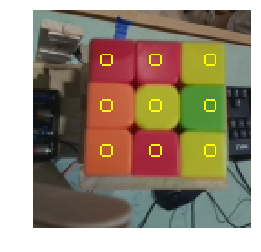

In [12]:
fig_mask = plt.figure()
ax = fig_mask.add_subplot(1,1,1)
ax.imshow(masks['D'])
plt.axis("off")

In [13]:
# this basically puts all the average color values for each square into a big table, so we can do some math
square_list = []
for face in face_order:
    for x in range(3):
        for y in range(3):
            r, g, b = squares[face][x,y]
            square_list.append([face, x, y, r, g, b])

columns = ['face', 'x', 'y', 'r', 'g', 'b']
square_frame = pd.DataFrame(square_list, columns=columns)

In [14]:
square_frame.head(10)

,face,x,y,r,g,b
0,U,0,0,45.28,121.20,160.16
1,U,0,1,69.80,143.20,175.60
2,U,0,2,200.08,103.12,66.40
3,U,1,0,50.00,128.84,163.12
4,U,1,1,177.60,179.20,181.00
5,U,1,2,79.08,150.36,53.52
6,U,2,0,191.48,89.32,50.20
7,U,2,1,63.56,140.52,40.44
8,U,2,2,164.16,173.20,32.88
9,R,0,0,66.20,136.68,50.20


### Our task is to assign each square a 'color.'  To do this, we try to group them (since the computer doesn't really know what 'color' is.

Looking at the colors on a plot, say red vs blue, we get this:

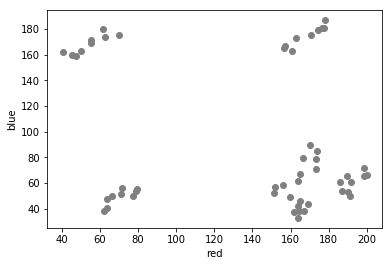

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(square_frame.r, square_frame.b, c='gray', marker='o')

ax.set_xlabel('red')
ax.set_ylabel('blue')

Now, how about red vs green vs blue (a 3d cross plot)?

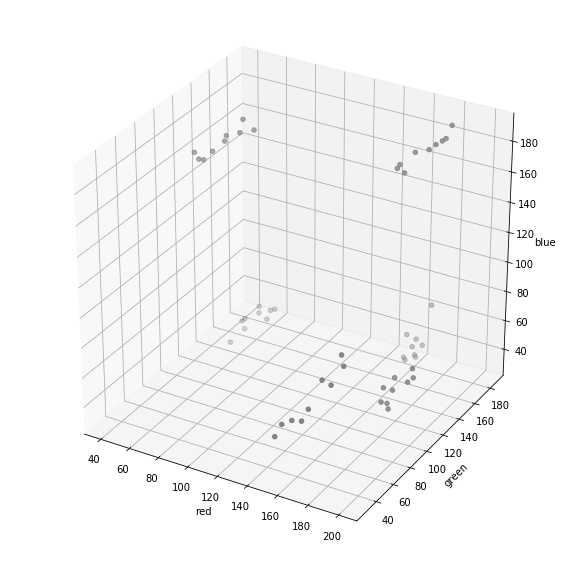

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(square_frame.r, square_frame.g, square_frame.b, c='gray', marker='o')

ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')

In [17]:
X = square_frame[['r', 'g', 'b']]

In [18]:
km = KMeans(n_clusters=6, random_state=123)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [19]:
km.cluster_centers_

array([[  70.55555556,  140.91555556,   49.23555556],
       [ 192.68444444,   95.65333333,   60.81777778],
       [  54.22666667,  132.56      ,  168.35111111],
       [ 168.30222222,  170.8       ,  174.48      ],
       [ 165.39555556,  168.77333333,   44.45777778],
       [ 163.61777778,   48.80444444,   69.80888889]])

In [20]:
centers_list = []
center_rgb = square_frame[(square_frame['x']==1) & (square_frame['y']==1)]
print center_rgb

   face  x  y       r       g       b
4     U  1  1  177.60  179.20  181.00
13    R  1  1  173.24   55.00   79.12
22    F  1  1   71.68  144.48   56.36
31    D  1  1  169.40  171.64   43.60
40    L  1  1  198.72   98.88   65.36
49    B  1  1   55.52  133.60  169.04


In [21]:
square_mapper = {}
center_map = km.predict(center_rgb[['r', 'g', 'b']])
for i in range(6):
    square_mapper[center_map[i]] = face_order[i]

In [22]:
center_map

array([3, 5, 0, 4, 1, 2])

In [23]:
square_mapper

{0: 'F', 1: 'L', 2: 'B', 3: 'U', 4: 'D', 5: 'R'}

In [24]:
square_predict = km.predict(square_frame[['r', 'g', 'b']])

In [25]:
squares = []
for square in square_predict:
    squares.append(square_mapper[square])

In [26]:
square_frame['predict'] = squares

In [27]:
square_color_map = {'U': 'black', 'R': 'red', 'F': 'green', 'D': 'yellow', 'L': 'orange', 'B': 'blue'}

In [28]:
square_colors = [square_color_map[sq] for sq in squares]

In [29]:
square_frame['colors'] = square_colors

In [30]:
square_frame[:15]

,face,x,y,r,g,b,predict,colors
0,U,0,0,45.28,121.20,160.16,B,blue
1,U,0,1,69.80,143.20,175.60,B,blue
2,U,0,2,200.08,103.12,66.40,L,orange
3,U,1,0,50.00,128.84,163.12,B,blue
4,U,1,1,177.60,179.20,181.00,U,black
5,U,1,2,79.08,150.36,53.52,F,green
6,U,2,0,191.48,89.32,50.20,L,orange
7,U,2,1,63.56,140.52,40.44,F,green
8,U,2,2,164.16,173.20,32.88,D,yellow
9,R,0,0,66.20,136.68,50.20,F,green


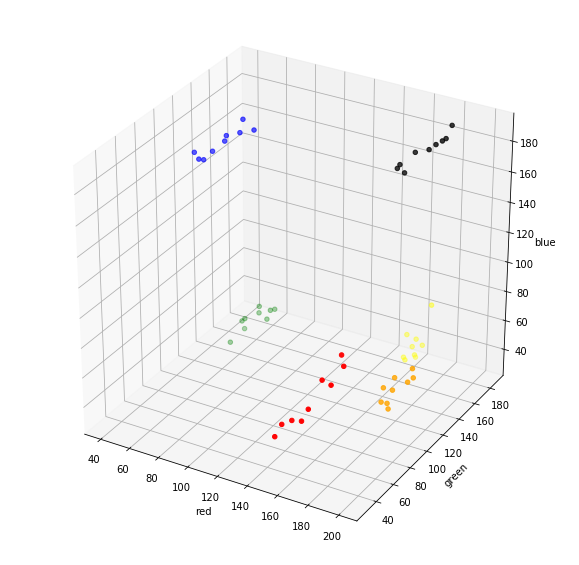

In [31]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(square_frame.r, square_frame.g, square_frame.b, c=square_frame.colors, marker='o')

ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')

In [32]:
import kociemba

In [33]:
kociemba.solve('URRDUUDRDRLBFRBBDUFBBBFLBRLLDUDDBDUFFLRRLUFFDUFLLBURFL')

u"D2 F' D2 R' U D2 F2 L' U R2 F D2 L2 D R2 D' R2 U' L2 U L2"